<img src="mioti.png" style="height: 100px">
<center style="color:#888">Data science fundamentals<br/>Asignatura Predictive Analytics</center>

# Worksheet S8: Casos sencillos de mantenimiento predictivo

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# import xgboost
import seaborn as sns
plt.rcParams['figure.figsize'] = 15,10

# RUL : Remaining usefull life


Usar esta métrica es algo bastante común, mide los ciclos/observaciones que quedan hasta el siguiente problema del equipo, de esta forma tenemos una variable sobre la que podemos hacer una regresión y en función a esto hacer alarmas cuando se sobrepasen determinados valores para llevar a cabo el debido mantenimiento.

Si tenemos una columna binaria donde indique dónde ha empezado algún problema podemos calcular también el RUL desde el origen de los datos operando con fechas en caso de tenerlas.

En el siguiente dataset tenemos datos de simulación de los sensores del ventilador de distintas turbinas de aviones :

    FD001, FD002 : En este experimento el activo estaba afectado por un único problema.
    FD003, FD004 : En este experimento los activos estaban afectados por dos problemas distintos.

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None,index_col=False,names=col_names)
train = train_df.copy()
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None,index_col=False,names=col_names)
test = test_df.copy()
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None,index_col=False,names=['RUL'])

Sólo se va a usar un dataset de entrenamiento y test pero en estos casos muchas veces uncluso se usa un tercero de evaluación para ver como se comporta el modelo con datos nuevos en dos ocasiones.

In [3]:
train_df.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [5]:
train_df['unit_number'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [6]:
train.describe()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Tenemos datos de 100 ventiladores de turbina distintos y tenemos los ciclos que estuvieron funcionando hasta que se pararon, así que para calcular el rul

In [7]:
def add_remaining_useful_life(df):
#     print(df)
    max_cycle = df.groupby(by='unit_number')['time_cycles'].max() 
#     print(max_cycle)
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), 
                            left_on='unit_number',
                            right_index=True )
    print(result_frame)
    remaining_useful_life = result_frame["max_cycle"] - result_frame['time_cycles']
    result_frame["RUL"] = remaining_useful_life 
    result_frame = result_frame.drop("max_cycle", axis=1) 
    return result_frame

In [8]:
train = add_remaining_useful_life(train)
train.head()

       unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  \
0      6

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
max_ruls = train.groupby('unit_number').max().reset_index()
max_ruls.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268


<AxesSubplot:xlabel='RUL', ylabel='Count'>

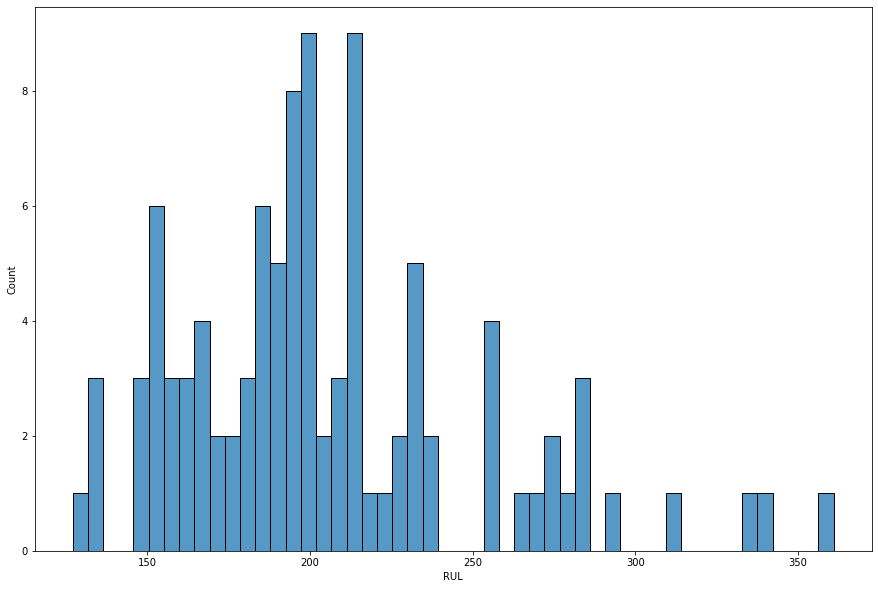

In [10]:
sns.histplot(data=max_ruls, x="RUL",bins=50)

Viendo estas distribuciones en estos datos podríamos concretar que el mantenimiento programado más conservador sería en torno a 150 ciclos, antes de esta cantidad no hemos encontrado ningún error y la gran mayoría de los errores ocurren en este rango de los 150, 260

### Visualización de las señales de los sensores

Vamos a ver para una serie de turbinas que aspecto tienen los valores de los distintos sensores para ver si hay algunas variables que no estén aportando información, para ello vamos a usar las primeras 20 turbinas y vamos a ir ploteando todas las variables una a una.


C:\Users\avitr\anaconda3\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


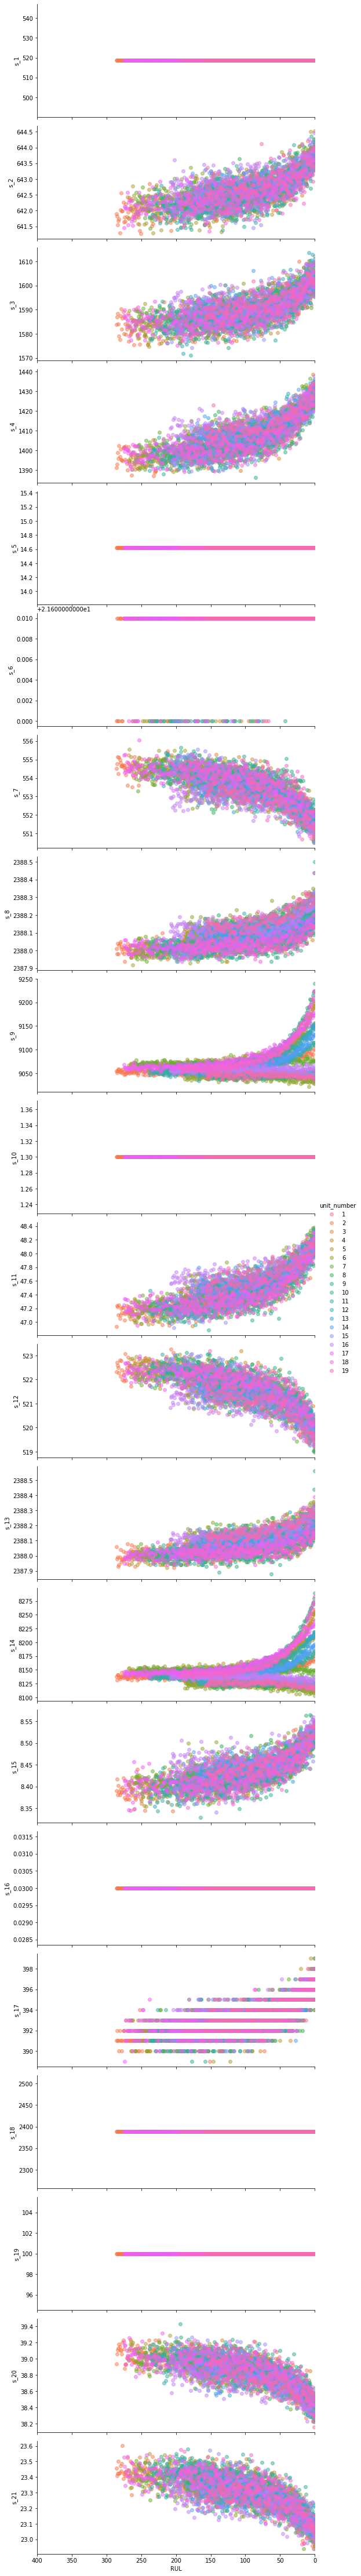

In [11]:
feat_plot = sns.PairGrid(data=train[train['unit_number'] < 20],x_vars='RUL',y_vars=sensor_names,hue="unit_number", size=3, aspect=2.5)
feat_plot = feat_plot.map(plt.scatter, alpha=0.5)
feat_plot = feat_plot.set(xlim=(400,0))
feat_plot = feat_plot.add_legend()

### Breve análisis de los sensores

Viendo el plot de los distintos sensores para las primeras 20 turbinas vemos que hay muchos de ellos que no está aportando ninguna información valiosa, como los sensores 1,5,16,18,19.

Así que por el momento vamos a deshacernos de todos estos sensores para no tener datos inútiles mejorando así la velocidad del algoritmo y  una mejor generalización del modelo y más tarde evaluaremos si hay algunos otros que no estén aportando información (como el sensor 6).


In [12]:
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10','s_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

Nos definimos una métrica de evaluación para nuestra regresión

In [13]:
def rmse(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### Entrenando el algoritmo


In [14]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train)


y_hat_train = rf.predict(X_train)
rmse(y_train, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
rmse(y_test, y_hat_test)

train set RMSE:15.427359262183176, R2:0.9498344619780185
test set RMSE:32.907012307409495, R2:0.37292806648515897


In [15]:
def visualizePredActual(actual,pred):
    df_vis=pd.DataFrame({'Actual values':actual,'Predicted values':pred})
    df_vis.plot( y=["Actual values", "Predicted values"], kind="bar")
    plt.show()

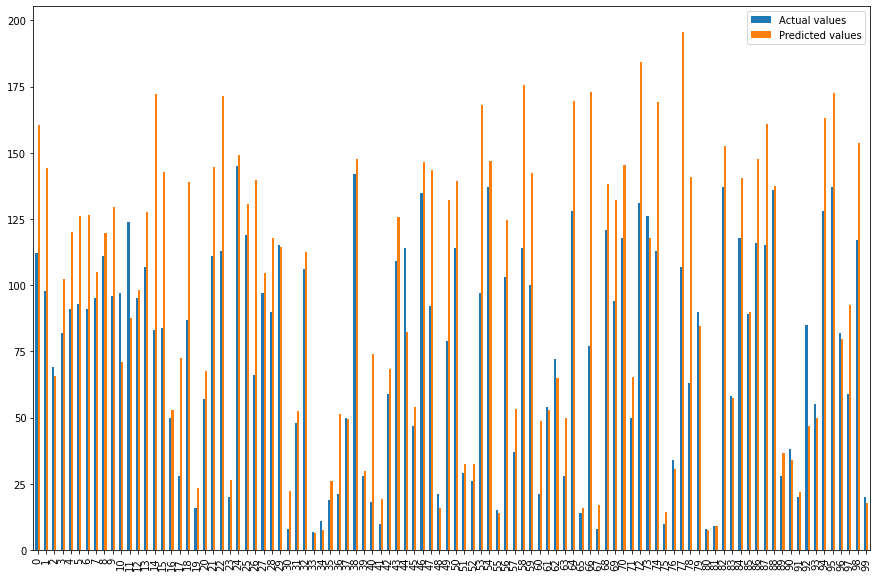

In [16]:
visualizePredActual(y_test['RUL'].values,y_hat_test)

Vemos de forma visual que para valores pequeños actua bien pero en cuando sube el RUL estamos siempre por encima sobre estimando.

Para paliar este efecto vamos a recortar para que el RUL máximo sea de 115 además es a partir de estos valores cuando el patrón de comportamiento de los sensores cambia.



In [17]:
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
        's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=115)  
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

<AxesSubplot:>

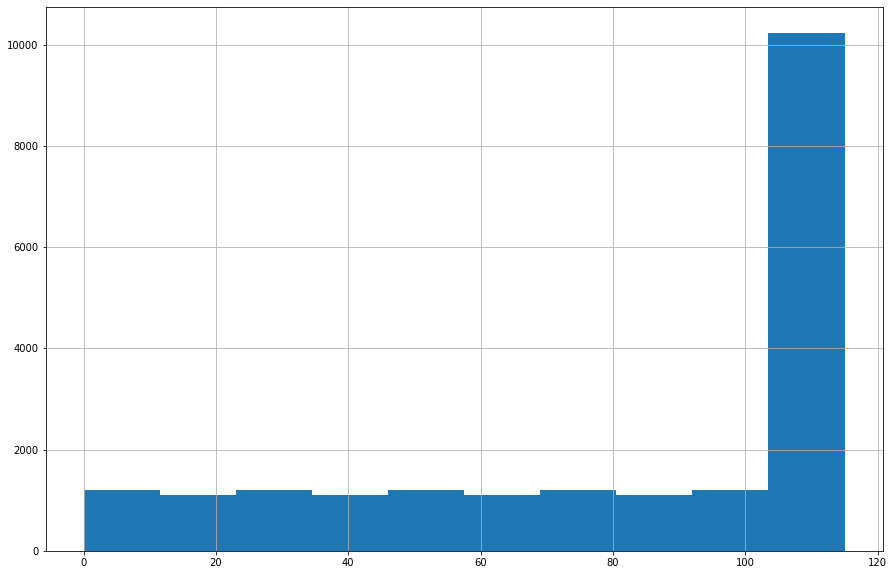

In [18]:
y_train_clipped.hist()

In [19]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)


y_hat_train = rf.predict(X_train)
rmse(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
rmse(y_test, y_hat_test)

train set RMSE:5.927136123388403, R2:0.9756741408874002
test set RMSE:18.073680837062494, R2:0.8108380974452268


Despues de haber colapsado esos valores altos de RUL en los que los sensores hemos visto que las métricas han mejorado bastante, vamos a ver que pasa con las predicciones

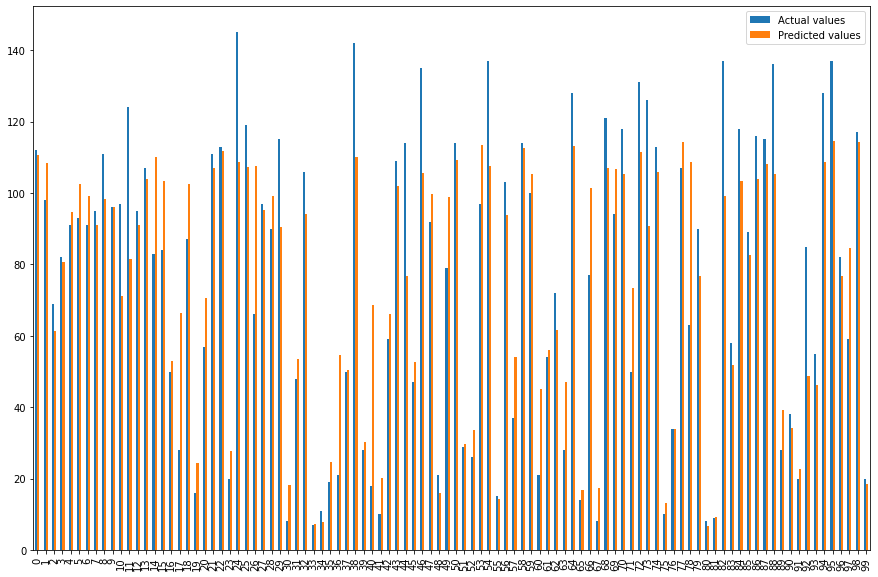

In [20]:
visualizePredActual(y_test['RUL'].values,y_hat_test)

Ya que hemos visto que las señales de los sensores fluctuan mucho en rangos muy pequeños, podemos hacer un suavizado de las señales de los mismos aplicando un filtro, algo parecido a lo que se hacía con la media móvil pero sin afectar tanto a la señal.



In [21]:
def apply_scipy_filter(df, scipy_filter):
    for unit in df['unit_number'].unique():
        for sensor in df.loc[:,'s_1':]:
            if sensor != 'RUL': 
                df.loc[df['unit_number']==unit,sensor] = scipy_filter(df.loc[df['unit_number']==unit,sensor], 
                window_length=19, polyorder=1, deriv=0, mode='interp')  
    return df

In [22]:
train = apply_scipy_filter(train, ss.savgol_filter)
train = apply_scipy_filter(train, ss.savgol_filter)
train = apply_scipy_filter(train, ss.savgol_filter)

test = apply_scipy_filter(test, ss.savgol_filter)
test = apply_scipy_filter(test, ss.savgol_filter)
test = apply_scipy_filter(test, ss.savgol_filter)

Volvemos a visualizar las señales

C:\Users\avitr\anaconda3\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


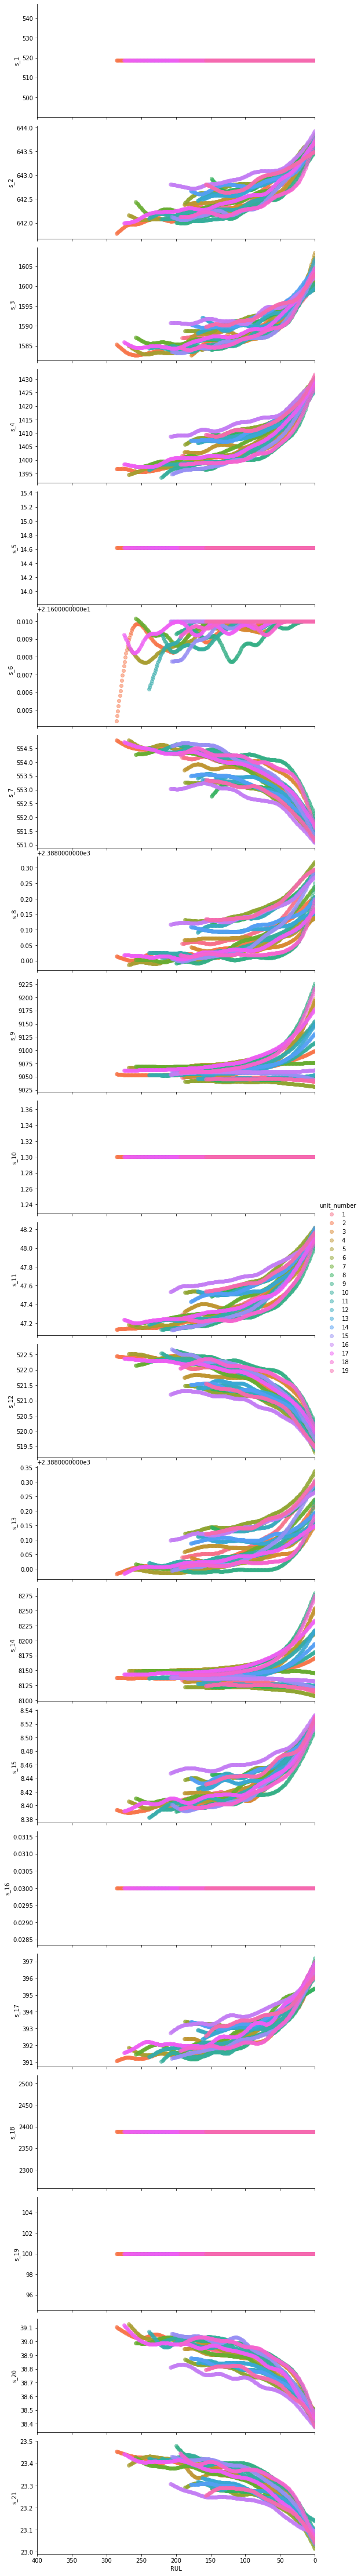

In [23]:
feat_plot = sns.PairGrid(data=train[train['unit_number'] < 20],x_vars='RUL',y_vars=sensor_names,hue="unit_number", size=3, aspect=2.5)
feat_plot = feat_plot.map(plt.scatter, alpha=0.5)
feat_plot = feat_plot.set(xlim=(400,0))
feat_plot = feat_plot.add_legend()

Vemos que ahora es mucho más suave y eso que estamos usando un scatter plot

In [24]:
drop_sensors = ['s_1','s_5','s_16','s_18','s_19'] 
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10','s_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125) 
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [25]:
X_train

,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,642.190191,1586.913154,1401.758885,21.61,554.177899,2388.054799,9048.991033,1.3,47.291333,522.158789,2388.039737,8133.432113,8.408639,391.716314,39.002885,23.390900
1,642.201301,1586.939070,1401.648297,21.61,554.172047,2388.055333,9049.054277,1.3,47.289992,522.148343,2388.040208,8133.358957,8.408846,391.732964,39.000575,23.390457
2,642.212410,1586.964986,1401.537708,21.61,554.166195,2388.055867,9049.117521,1.3,47.288650,522.137897,2388.040679,8133.285801,8.409053,391.749614,38.998265,23.390015
3,642.223520,1586.990902,1401.427120,21.61,554.160343,2388.056401,9049.180766,1.3,47.287309,522.127450,2388.041150,8133.212646,8.409260,391.766263,38.995955,23.389572
4,642.234630,1587.016818,1401.316532,21.61,554.154491,2388.056935,9049.244010,1.3,47.285968,522.117004,2388.041621,8133.139490,8.409467,391.782913,38.993646,23.389129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.495648,1601.195437,1428.642394,21.61,551.202536,2388.234827,9066.846360,1.3,48.164852,519.720105,2388.241533,8139.835358,8.522874,395.970647,38.387533,23.068354
20627,643.506848,1601.402078,1429.118414,21.61,551.153979,2388.237000,9066.866508,1.3,48.179484,519.678053,2388.243818,8139.725210,8.524633,396.010701,38.377431,23.063397
20628,643.518049,1601.608719,1429.594435,21.61,551.105422,2388.239172,9066.886655,1.3,48.194115,519.636000,2388.246103,8139.615062,8.526392,396.050756,38.367328,23.058440
20629,643.529249,1601.815360,1430.070455,21.61,551.056866,2388.241345,9066.906802,1.3,48.208747,519.593948,2388.248388,8139.504914,8.528151,396.090810,38.357226,23.053483


In [26]:
rf = RandomForestRegressor(n_estimators = 32,max_depth = 22,min_samples_split = 6,max_features = 1,min_samples_leaf = 8,random_state = 42)
rf.fit(X_train, y_train_clipped)

y_hat_train = rf.predict(X_train)
rmse(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
rmse(y_test, y_hat_test)

train set RMSE:8.964141503912153, R2:0.9537284167333859
test set RMSE:18.94835473645683, R2:0.7920861267008198


# Detección de anomalías Isolation forest

Tenemos un dataset con los datos de una prensa en la que hemos hecho una serie de mediciones de las distintas aceleraciones en los 3 ejes y el valor de G para cuatro situaciones distintas a un ratio de 100 Hz


    1. Nada acoplado a la prensa
    2. Una base de madera acoplada a la prensa
    3. Desbalance creado por añadir peso en un extremo de la base de madera
    4. Desbalance creado por añadir dos pesos en dos extremos de la base

In [27]:
df_base = pd.read_csv('base.csv')
df_dry_run = pd.read_csv('dry run.csv')
df_imb1 = pd.read_csv('imbalance 1.csv')
df_imb2 = pd.read_csv('imbalance 2.csv')

Elegimos un dataset objetivo

In [28]:
df_target = df_base

In [29]:
df_target.head()

,time,ax,ay,az,aT
0,0.004,-0.5076,-0.2454,-0.2490,0.616
1,0.006,-0.1173,0.2752,1.3013,1.335
2,0.008,0.0114,-0.6306,0.3460,0.719
3,0.019,-0.4323,-0.7868,-0.3854,0.977
4,0.034,-0.6198,-0.4897,0.0300,0.790


In [30]:
df_target.describe()

,time,ax,ay,az,aT
count,10802.000000,10802.000000,10802.000000,10802.000000,10802.000000
mean,54.085818,0.005385,-0.002534,-0.091051,0.926056
std,31.236734,0.438251,0.525020,0.749907,0.425127
min,0.004000,-1.402700,-1.693300,-3.189300,0.036000
25%,27.004500,-0.311100,-0.429600,-0.573375,0.627000
50%,54.141500,0.015100,-0.010700,-0.118350,0.867000
75%,81.145750,0.314800,0.419475,0.348150,1.155000
max,108.127000,1.771900,1.515600,5.046100,5.295000


Checkeamos la distribución y correlación de las distintas variables

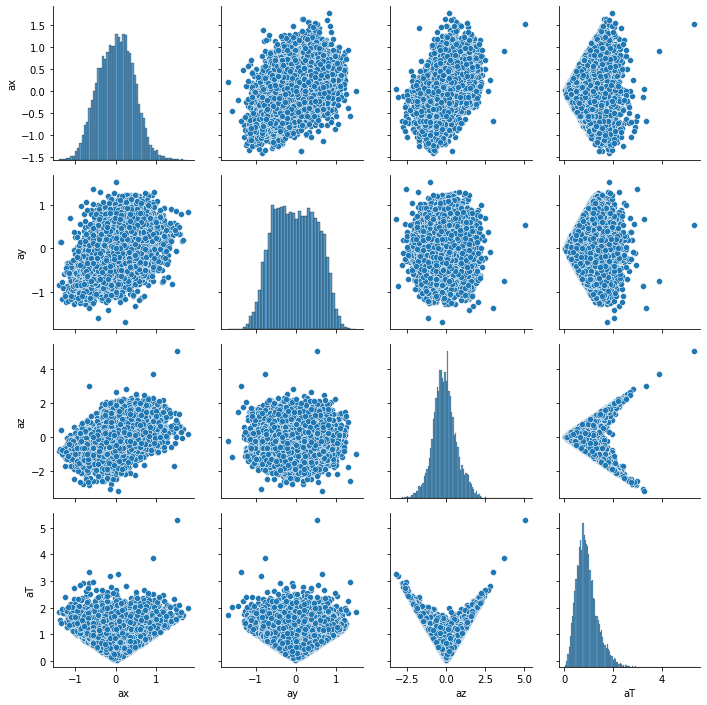

In [31]:
g = sns.PairGrid(df_target[['ax','ay','az','aT']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

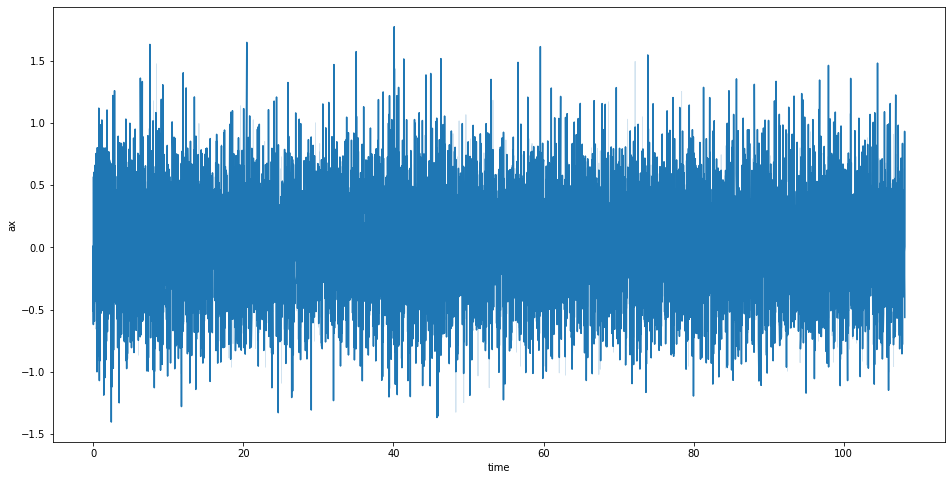

In [32]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target.time, y = "ax", data = df_target)
plt.show()

In [33]:
from sklearn.ensemble import IsolationForest

El siguiente parámetro es bastante importante, le estamos indicando la proporción esperada de anomalías en este tipo de datos, con un valor de 0.05 le estaríamos indicando que hay un 5% de las observaciones que contienen anomalías

In [34]:
contaminationValue = 0.05

In [35]:
anomalyModel  =  IsolationForest(n_estimators=50, max_samples=5000, contamination=contaminationValue, max_features=4, bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(df_target[['ax','ay','az','aT']].values)

Una vez entrenado el modelo podemos obtener tanto la predicción de si es un dato normal (1) o un dato anómalo (-1) y además podemos obtener la puntuación que ha obtenido para cada uno

In [36]:
anomaly_score = anomalyModel.decision_function(df_target[['ax','ay','az','aT']])
predictions = anomalyModel.predict(df_target[['ax','ay','az','aT']])

C:\Users\avitr\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\avitr\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [37]:
anomaly_score

array([ 0.09859432,  0.04436369,  0.10344353, ..., -0.01376747,
        0.05119867,  0.09855936])

In [38]:
predictions

array([ 1,  1,  1, ..., -1,  1,  1])

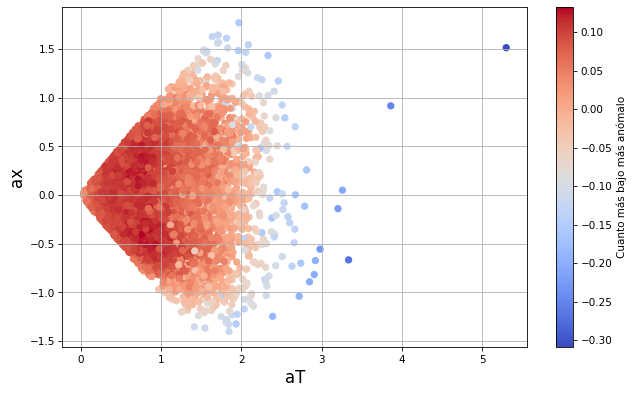

In [39]:
plt.figure(figsize = (10, 6), dpi = 75)
s = plt.scatter(df_target['aT'], df_target['ax'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'Cuanto más bajo más anómalo')
plt.xlabel('aT', fontsize = 16)
plt.ylabel('ax', fontsize = 16)
plt.grid()

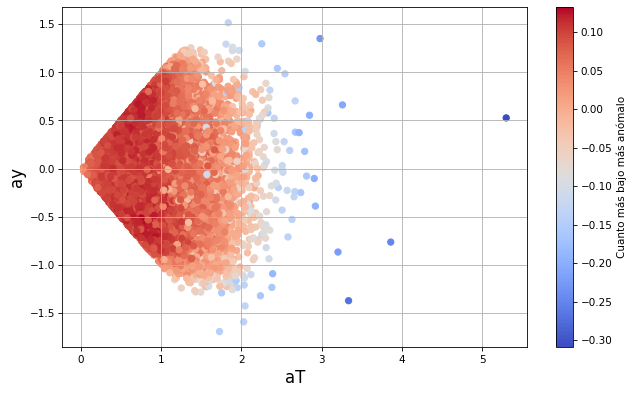

In [40]:
plt.figure(figsize = (10, 6), dpi = 75)
s = plt.scatter(df_target['aT'], df_target['ay'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'Cuanto más bajo más anómalo')
plt.xlabel('aT', fontsize = 16)
plt.ylabel('ay', fontsize = 16)
plt.grid()

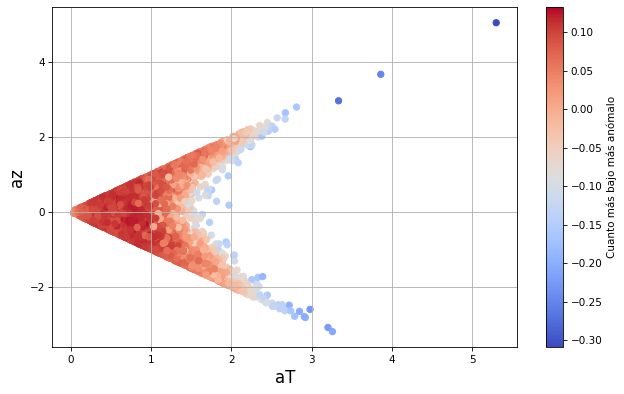

In [41]:
plt.figure(figsize = (10, 6), dpi = 75)
s = plt.scatter(df_target['aT'], df_target['az'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'Cuanto más bajo más anómalo')
plt.xlabel('aT', fontsize = 16)
plt.ylabel('az', fontsize = 16)
plt.grid()

In [42]:
df_target['Score'] = anomaly_score
df_target['Outlier'] = predictions

In [43]:
df_target['Outlier'] = df_target['Outlier'].replace({1:0,-1:1})

In [44]:
anomalies = df_target[df_target['Outlier']==1][['time','ax']]

In [45]:
anomalies

,time,ax
18,0.171,0.1772
53,0.513,-0.9996
77,0.752,1.1179
79,0.782,-0.6988
83,0.812,-0.3046
...,...,...
10689,107.020,-0.2867
10734,107.509,-0.1495
10755,107.666,0.1267
10762,107.735,-0.4968


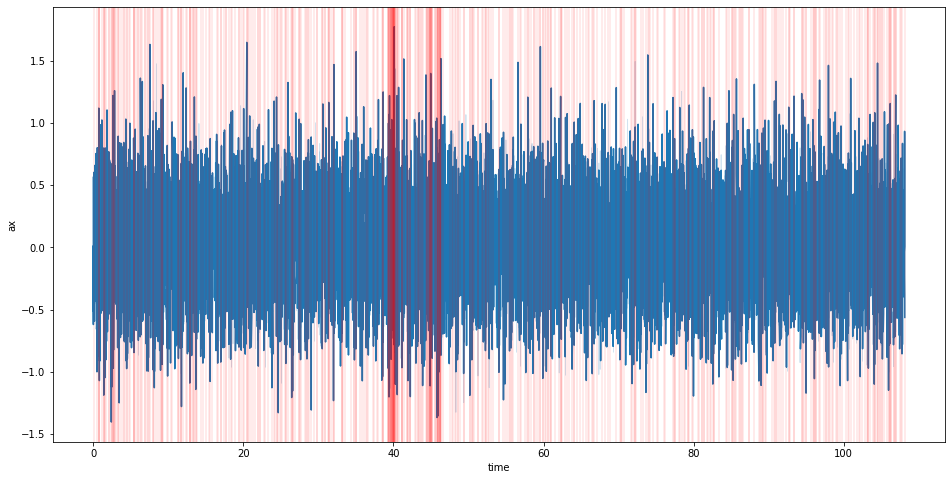

In [46]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target.time, y = "ax", data = df_target)
for element in anomalies.time:
    plt.axvline(element, color='r',alpha=0.1)
plt.show()

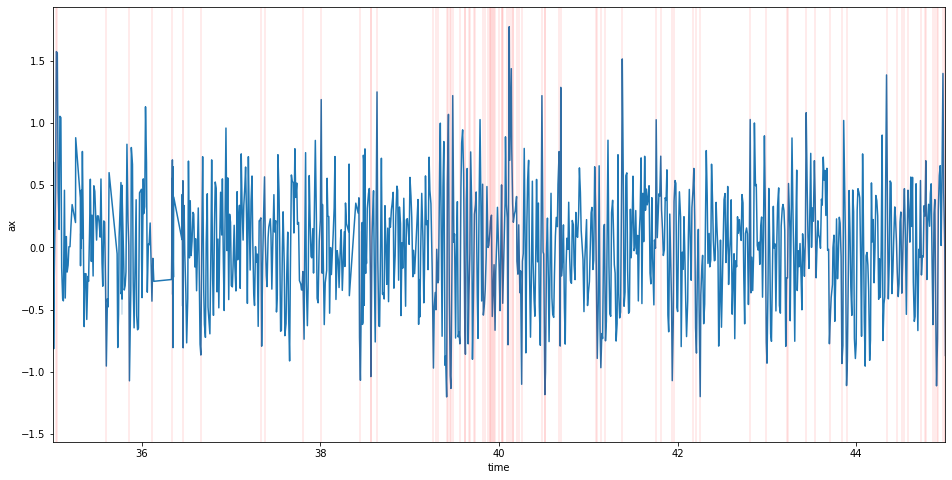

In [47]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target.time, y = "ax", data = df_target)
graph.set_xlim(35,45)
for element in anomalies.time:
    plt.axvline(element, color='r',alpha=0.1)
plt.show()

### Más restrictivos con el criterio

In [48]:
Q1 = df_target['Score'].quantile(0.25)
Q3 = df_target['Score'].quantile(0.75)
IQR = Q3 - Q1

In [49]:
df_target['Outlier 2'] = df_target['Score'].apply(lambda x : 0 if x >  (Q1 - 3 * IQR) and x < (Q3 + 3 * IQR)  else 1) ## 

In [50]:
df_target['Outlier 2']

0        0
1        0
2        0
3        0
4        0
        ..
10797    0
10798    0
10799    0
10800    0
10801    0
Name: Outlier 2, Length: 10802, dtype: int64

In [51]:
anomalies2 = df_target[df_target['Outlier 2']==1][['time','ax']]

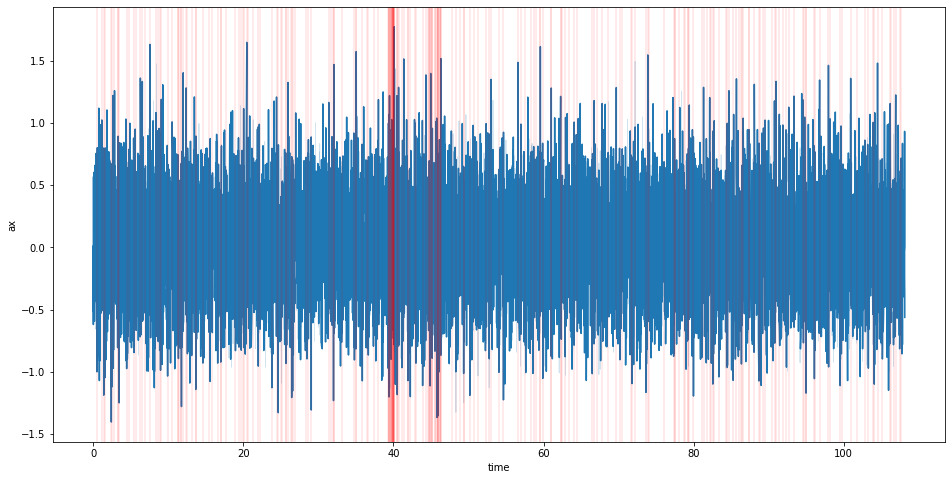

In [52]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target.time, y = "ax", data = df_target)
for element in anomalies2.time:
    plt.axvline(element, color='r',alpha=0.1)
plt.show()

In [53]:
df_target['Outlier 2'].value_counts()

0    10546
1      256
Name: Outlier 2, dtype: int64

In [54]:
df_target['Outlier'].value_counts()

0    10261
1      541
Name: Outlier, dtype: int64

**P ¿Tiene sentido la forma en la que hemos aplicado esta imposición más restrictiva?**

### Tercera restricción, dejar sólo aquellas concentraciones superiores a 25 anomalías en ventanas de 40

In [55]:
df_target

,time,ax,ay,az,aT,Score,Outlier,Outlier 2
0,0.004,-0.5076,-0.2454,-0.2490,0.616,0.098594,0,0
1,0.006,-0.1173,0.2752,1.3013,1.335,0.044364,0,0
2,0.008,0.0114,-0.6306,0.3460,0.719,0.103444,0,0
3,0.019,-0.4323,-0.7868,-0.3854,0.977,0.120737,0,0
4,0.034,-0.6198,-0.4897,0.0300,0.790,0.111547,0,0
...,...,...,...,...,...,...,...,...
10797,108.102,0.9316,-0.2238,-0.3907,1.035,0.004026,0,0
10798,108.103,0.3385,-0.4296,1.3415,1.449,0.062766,0,0
10799,108.104,-0.2312,0.4899,-1.8908,1.967,-0.013767,1,0
10800,108.125,-0.4099,0.6758,-0.8373,1.151,0.051199,0,0


In [56]:
df_target['Sld wind 40'] = df_target['Outlier 2'].rolling(250).sum()

<AxesSubplot:>

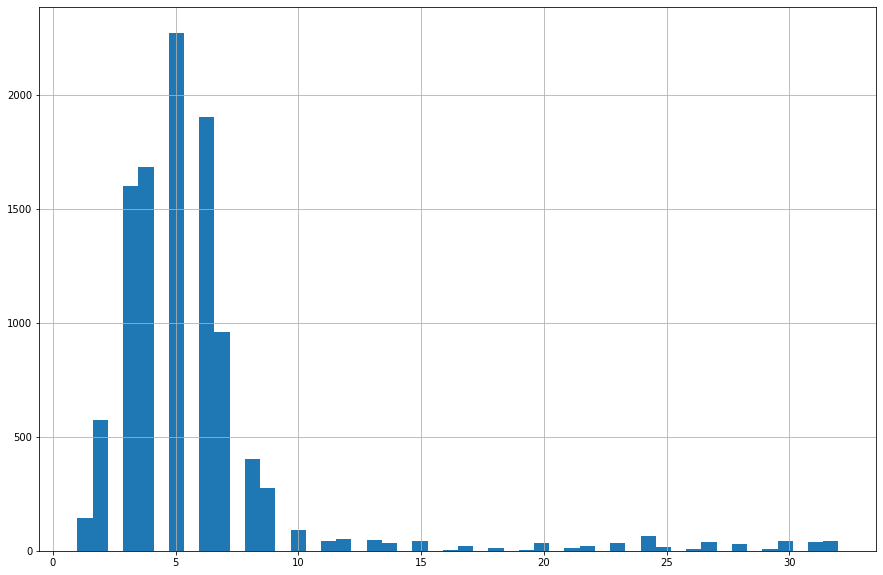

In [57]:
df_target['Sld wind 40'].hist(bins=50)

In [58]:
df_target['Outlier 3'] = df_target['Sld wind 40'].apply(lambda x: 1 if x > 20 else 0 )

In [59]:
anomalies3 = df_target[df_target['Outlier 3']==1][['time','ax']]

In [62]:
anomalies3

,time,ax
3989,39.956,-0.6657
3990,39.964,-0.1966
3991,39.975,0.0460
3992,39.983,0.3213
3993,40.002,-0.1877
...,...,...
4717,47.283,-0.6972
4718,47.292,-0.5184
4719,47.302,0.2347
4720,47.314,0.4438


In [63]:
df_target

,time,ax,ay,az,aT,Score,Outlier,Outlier 2,Sld wind 40,Outlier 3
0,0.004,-0.5076,-0.2454,-0.2490,0.616,0.098594,0,0,NaN,0
1,0.006,-0.1173,0.2752,1.3013,1.335,0.044364,0,0,NaN,0
2,0.008,0.0114,-0.6306,0.3460,0.719,0.103444,0,0,NaN,0
3,0.019,-0.4323,-0.7868,-0.3854,0.977,0.120737,0,0,NaN,0
4,0.034,-0.6198,-0.4897,0.0300,0.790,0.111547,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...
10797,108.102,0.9316,-0.2238,-0.3907,1.035,0.004026,0,0,6.0,0
10798,108.103,0.3385,-0.4296,1.3415,1.449,0.062766,0,0,6.0,0
10799,108.104,-0.2312,0.4899,-1.8908,1.967,-0.013767,1,0,6.0,0
10800,108.125,-0.4099,0.6758,-0.8373,1.151,0.051199,0,0,6.0,0


In [64]:
df_target

,time,ax,ay,az,aT,Score,Outlier,Outlier 2,Sld wind 40,Outlier 3
0,0.004,-0.5076,-0.2454,-0.2490,0.616,0.098594,0,0,NaN,0
1,0.006,-0.1173,0.2752,1.3013,1.335,0.044364,0,0,NaN,0
2,0.008,0.0114,-0.6306,0.3460,0.719,0.103444,0,0,NaN,0
3,0.019,-0.4323,-0.7868,-0.3854,0.977,0.120737,0,0,NaN,0
4,0.034,-0.6198,-0.4897,0.0300,0.790,0.111547,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...
10797,108.102,0.9316,-0.2238,-0.3907,1.035,0.004026,0,0,6.0,0
10798,108.103,0.3385,-0.4296,1.3415,1.449,0.062766,0,0,6.0,0
10799,108.104,-0.2312,0.4899,-1.8908,1.967,-0.013767,1,0,6.0,0
10800,108.125,-0.4099,0.6758,-0.8373,1.151,0.051199,0,0,6.0,0


In [65]:
anomalies3

,time,ax
3989,39.956,-0.6657
3990,39.964,-0.1966
3991,39.975,0.0460
3992,39.983,0.3213
3993,40.002,-0.1877
...,...,...
4717,47.283,-0.6972
4718,47.292,-0.5184
4719,47.302,0.2347
4720,47.314,0.4438


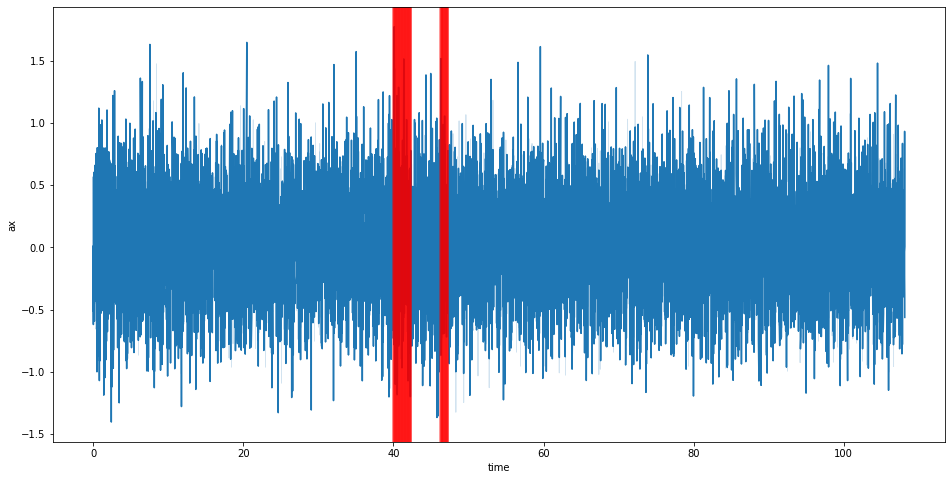

In [60]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target.time, y = "ax", data = df_target)
for element in anomalies3.time:
    plt.axvline(element, color='r',alpha=0.1)
plt.show()

In [61]:
anomalies3

,time,ax
3989,39.956,-0.6657
3990,39.964,-0.1966
3991,39.975,0.0460
3992,39.983,0.3213
3993,40.002,-0.1877
...,...,...
4717,47.283,-0.6972
4718,47.292,-0.5184
4719,47.302,0.2347
4720,47.314,0.4438


### Visualización de los datos en este rango

In [68]:
timeMin = anomalies3['time'].min()
timeMax = anomalies3['time'].max()

In [69]:
timeMin

39.956

In [70]:
timeMax

47.322

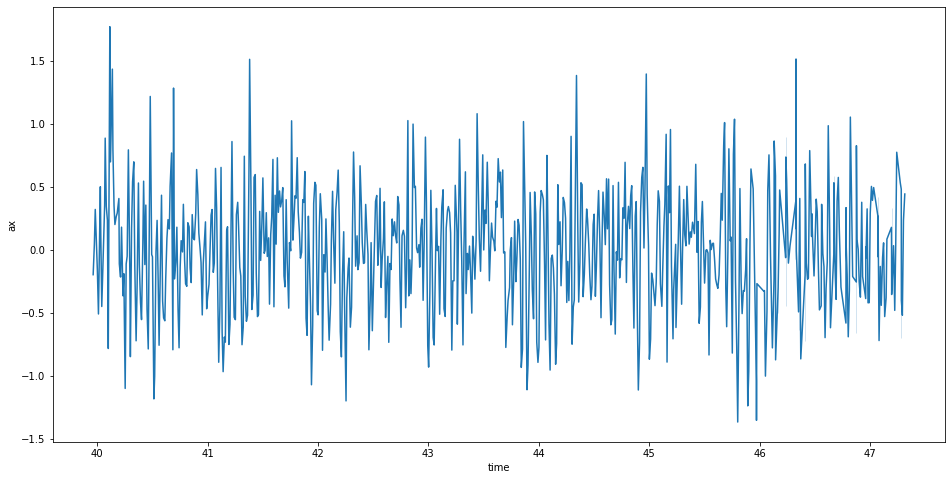

In [71]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)].time, y = "ax", data = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)])
plt.show()

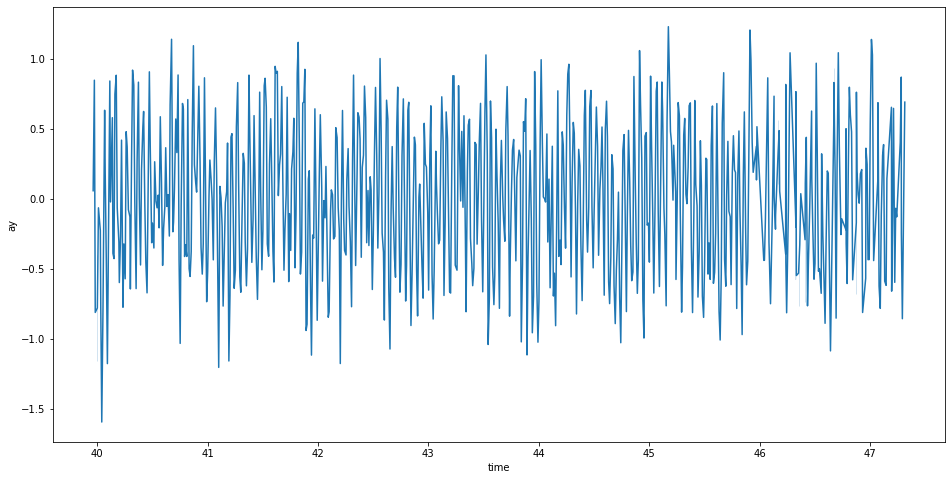

In [72]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)].time, y = "ay", data = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)])
plt.show()

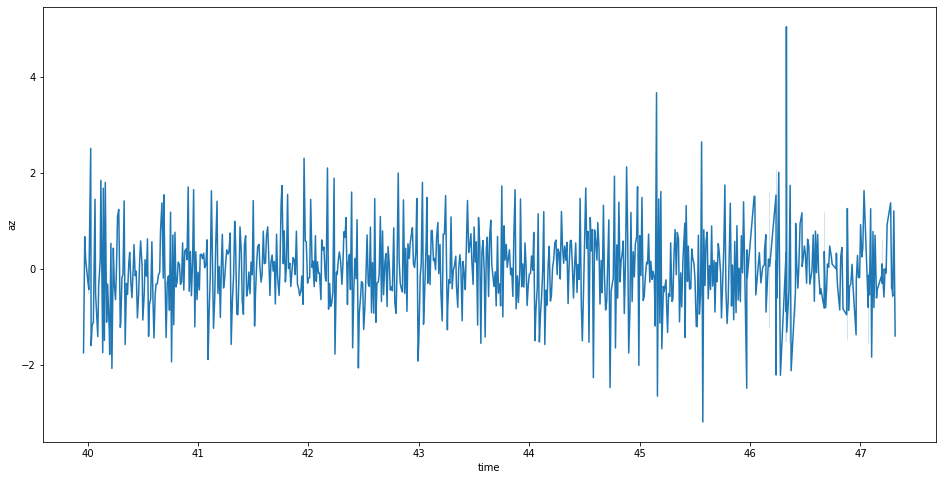

In [73]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)].time, y = "az", data = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)])
plt.show()

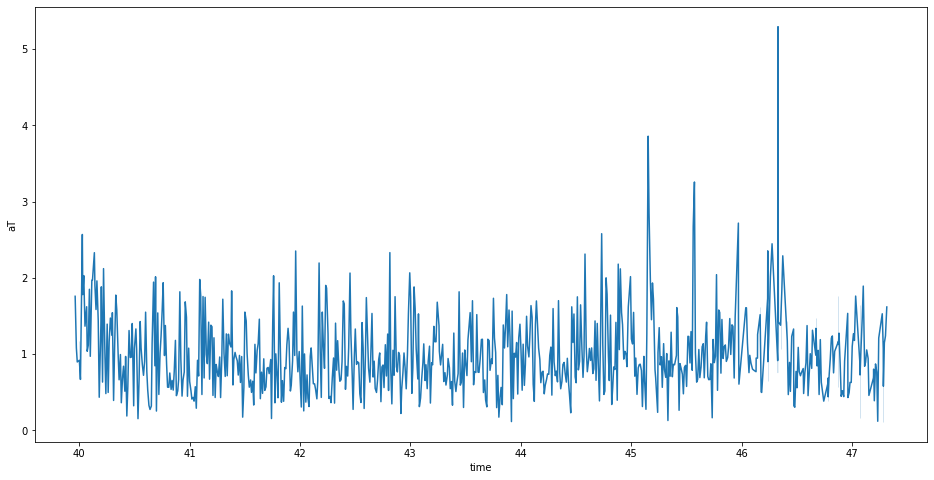

In [74]:
plt.figure(figsize=(16,8))
graph = sns.lineplot(x = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)].time, y = "aT", data = df_target[(df_target['time']>timeMin) & (df_target['time']<timeMax)])
plt.show()